#### *** Adjust the path parameter to user local catalog location.***

In [1]:
# Local directory path for the file : 'gz2_hart16_small.csv'
dir_cat = "/home/hhg/Research/galaxyClassify/catalog/galaxyZoo/zoo2/"

## ------------ start ------------

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%config InlineBackend.figure_format='retina'

In [3]:
df = pd.read_csv(dir_cat+'classAll_4label.csv')
df

,galaxyID,label1,label2,label3,label4
0,110939,0,0,0,0
1,187749,0,0,0,0
2,162781,0,0,0,0
3,154143,0,0,0,0
4,12450,0,0,0,0
...,...,...,...,...,...
155981,260790,7,4,3,2
155982,250189,7,4,3,2
155983,115591,7,4,3,2
155984,271627,7,4,3,2


In [4]:
df.groupby(['label1']).size()

label1
0    33904
1    39204
2     7416
3    16351
4    20414
5    30662
6     5934
7     2101
dtype: int64

## data_split

In [5]:
file_csv = dir_cat+'classAll_4label.csv'
f_train = 0.64
f_valid = 0.16
f_test  = 0.20
seed = 3

In [6]:
# import sys
# sys.path.append('../galaxyZooNet/')
# from data_loader import data_split

import pandas as pd
from sklearn.model_selection import train_test_split

def data_split(file_csv, f_train=0.64, f_valid=0.16, f_test=0.20, random_state=None, stats=False):
    '''train-valid-test splits
        Args:
            file_csv (str) : path to the full catalog csv file
            f_train, f_valid, f_test : fractions of training, validation, test samples
            stats (bool): display splitting statistics if True 
        Returns:
            df_train (pd.dataframes) : splitted training sample
            df_valid (pd.dataframes) :          validation
            df_test  (pd.dataframes) :          test
    '''
    assert f_train + f_valid + f_test == 1, 'fractions have to sum to 1.'

    df = pd.read_csv(file_csv)

    df_train, df_temp = train_test_split(df, train_size=f_train, random_state=random_state)
    relative_f_valid = f_valid/(f_valid+f_test)
    df_valid, df_test = train_test_split(df_temp, train_size=relative_f_valid, random_state=random_state)
    
    if stats:
        df_stats=df.groupby(['label1']).label1.agg('count').to_frame('count').reset_index()
        df_stats['full'] = df_stats['count']/df_stats['count'].sum()
        df_stats['train'] = df_train.groupby(['label1']).size()/df_train.groupby(['label1']).size().sum()
        df_stats['valid'] = df_valid.groupby(['label1']).size()/df_valid.groupby(['label1']).size().sum()
        df_stats['test'] = df_test.groupby(['label1']).size()/df_test.groupby(['label1']).size().sum()
        
        ax = df_stats.plot.bar(x='label1', y=['full', 'train', 'valid', 'test'], rot=0)
        ax.set_ylabel('class fraction')
            
    return df_train.reset_index(drop=True), df_valid.reset_index(drop=True), df_test.reset_index(drop=True)

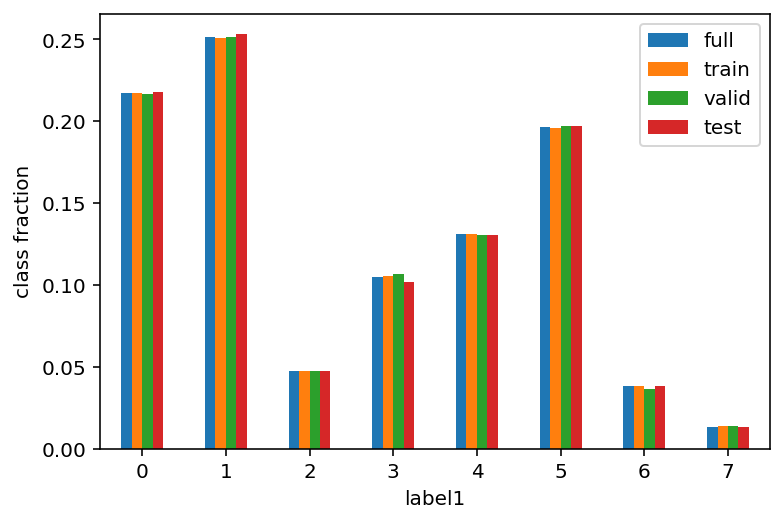

In [7]:
df_train, df_valid, df_test = data_split(file_csv, f_train, f_valid, f_test, random_state=seed, stats=True)

In [8]:
df_train

,galaxyID,label1,label2,label3,label4
0,126161,4,2,1,1
1,295049,2,0,0,0
2,195019,6,3,2,2
3,54615,2,0,0,0
4,12497,4,2,1,1
...,...,...,...,...,...
99826,18638,0,0,0,0
99827,39897,4,2,1,1
99828,78013,1,0,0,0
99829,164338,2,0,0,0


## GalaxyZooDataset

In [9]:
# import sys
# sys.path.append('../galaxyZooNet/')
# from data_loader import GalaxyZooDataset

import os
from PIL import Image
from torch.utils.data import Dataset

class GalaxyZooDataset(Dataset):
    '''Galaxy Zoo 2 image dataset
        Args:
            dataframe : pd.dataframe, outputs from the data_split function
                e.g. df_train / df_valid / df_test
            dir_image : str, path where galaxy images are located
            label_tag : str, class label system to be used for training
                e.g. label_tag = 'label1' / 'label2' / 'label3' / 'label4'
    '''

    def __init__(self, dataframe, dir_image, label_tag='label1', transform=None):
        self.df = dataframe
        self.transform = transform
        self.dir_image = dir_image
        self.label_tag = label_tag

    
    def __getitem__(self, index):
        galaxyID = self.df.iloc[[index]].galaxyID.values[0]
        file_img = os.path.join(self.dir_image, str(galaxyID) + '.jpg')
        image = Image.open(file_img)

        if self.transform:
            image = self.transform(image)
        
        label = self.df.iloc[[index]][self.label_tag].values[0]

        return image, label

    def __len__(self):
        return len(self.df)

``dir_image`` : path to the [galaxy zoo 2 images](https://www.kaggle.com/jaimetrickz/galaxy-zoo-2-images)

In [10]:
dir_image = '/home/hhg/Research/galaxyClassify/catalog/galaxyZoo_kaggle/gz2_images/images'
dataset_train = GalaxyZooDataset(df_train, dir_image, label_tag='label1')

In [11]:
i = 34
df_train.iloc[[i]]

,galaxyID,label1,label2,label3,label4
34,173224,4,2,1,1


label1 = 4


(-0.5, 423.5, 423.5, -0.5)

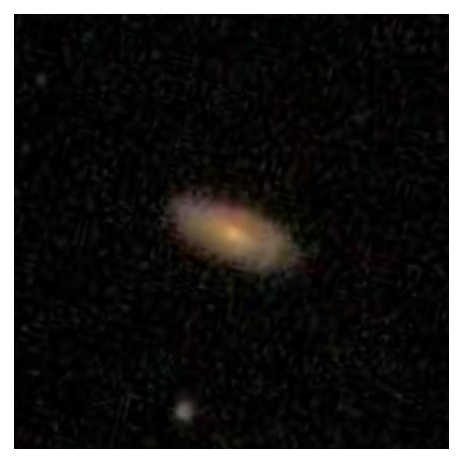

In [12]:
image_i, label_i = dataset_train[i]
print('label1 =',label_i)

fig, ax = plt.subplots()
ax.imshow(image_i)
ax.axis('off')

## dataloader

In [13]:
from torch.utils.data import DataLoader

In [14]:
import torchvision.transforms as transforms

def create_data_transforms(is_for_inception=False):
    """
    Create Pytorch data transforms for the GalaxyZoo datasets.
    Args:
        is_for_inception (bool): True for inception neural networks
    Outputs:
        train_transform: transform for the training data
        test_transform: transform for the testing data
    """
    if is_for_inception:
        input_size = 299
    else:
        input_size = 224

    # transforms for training data
    train_transform = transforms.Compose([transforms.CenterCrop(input_size),
                                          transforms.RandomRotation(90),
                                          transforms.RandomHorizontalFlip(),
                                          transforms.RandomVerticalFlip(),
                                          transforms.RandomResizedCrop(input_size, scale=(0.8, 1.0), ratio=(0.99, 1.01)),
                                          transforms.ToTensor(),
                                          transforms.Normalize([0, 0, 0], [255, 255, 255]),
                                          transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])

    # transforms for validation data
    valid_transform = transforms.Compose([transforms.CenterCrop(input_size),
                                          transforms.RandomRotation(90),
                                          transforms.RandomHorizontalFlip(),
                                          transforms.RandomVerticalFlip(),
                                          transforms.RandomResizedCrop(input_size, scale=(0.8, 1.0), ratio=(0.99, 1.01)),
                                          transforms.ToTensor(),
                                          transforms.Normalize([0, 0, 0], [255, 255, 255]),
                                          transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])  

    # transforms for test data
    test_transform = transforms.Compose([transforms.CenterCrop(input_size),
                                         transforms.ToTensor(),
                                         transforms.Normalize([0, 0, 0], [255, 255, 255]),
                                         transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])

    
    return train_transform, valid_transform, test_transform

In [15]:
BATCH_SIZE = 32

# create transforms
train_transform, valid_transform, test_transform = create_data_transforms(is_for_inception=False)

# create datasets
data_train = GalaxyZooDataset(df_train, dir_image, transform=train_transform, label_tag='label1')
data_valid = GalaxyZooDataset(df_valid, dir_image, transform=valid_transform, label_tag='label1')
data_test  = GalaxyZooDataset(df_test , dir_image, transform=test_transform , label_tag='label1')

# dataloaders
train_loader = DataLoader(data_train, batch_size=BATCH_SIZE, shuffle=True)
valid_loader = DataLoader(data_valid, batch_size=BATCH_SIZE, shuffle=True)
test_loader  = DataLoader(data_test , batch_size=BATCH_SIZE, shuffle=True)

# check the sizes
print("Number of training data: {} ({} batches)".format(len(data_train), len(train_loader)))
print("Number of validation data: {} ({} batches)".format(len(data_valid), len(valid_loader)))
print("Number of test data: {} ({} batches)".format(len(data_test), len(test_loader)))

Number of training data: 99831 (3120 batches)
Number of validation data: 24957 (780 batches)
Number of test data: 31198 (975 batches)
